In [2]:
import librosa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import IPython.display as ipd

In [3]:
note_table = pd.read_csv("../../../Data/Piano/Note_table.tsv", header=0, sep="\t")

Here we will use audio files of individual notes played consecutively on the same string.

In [4]:
ipd.Audio("../../../Samples/Guitar/Ind_notes/Guitar_noamp_string1_0.mp3")

Notes are always 4000 samples apart

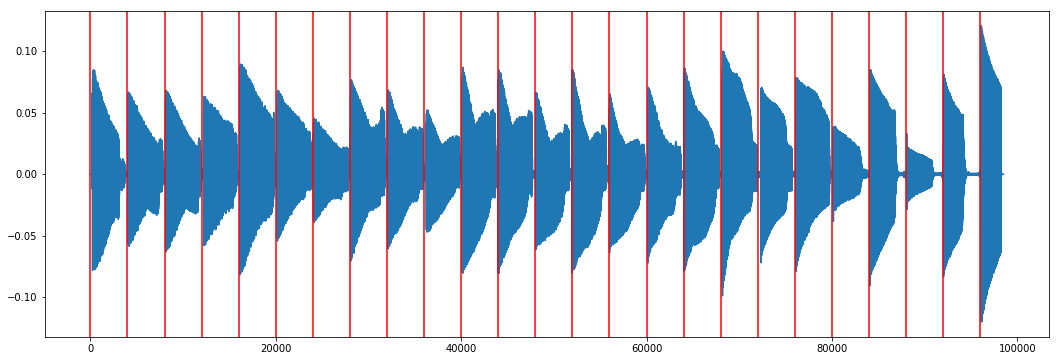

In [511]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in range(0, len(y), 4000):
    plt.axvline(x=i, color="r")

## Strings and notes

Establish where the notes are on each string

In [8]:
start_8 = note_table[note_table["Note"] == "E1"].index[0]
start_7 = note_table[note_table["Note"] == "B1"].index[0]
start_6 = note_table[note_table["Note"] == "E2"].index[0]
start_5 = note_table[note_table["Note"] == "A2"].index[0]
start_4 = note_table[note_table["Note"] == "D3"].index[0]
start_3 = note_table[note_table["Note"] == "G3"].index[0]
start_2 = note_table[note_table["Note"] == "B3"].index[0]
start_1 = note_table[note_table["Note"] == "E4"].index[0]

In [9]:
strings = {
    "8": note_table["Note"].iloc[start_8:start_8+25].values,
    "7": note_table["Note"].iloc[start_7:start_7+25].values,
    "6": note_table["Note"].iloc[start_6:start_6+25].values,
    "5": note_table["Note"].iloc[start_5:start_5+25].values,
    "4": note_table["Note"].iloc[start_4:start_4+25].values,
    "3": note_table["Note"].iloc[start_3:start_3+25].values,
    "2": note_table["Note"].iloc[start_2:start_2+25].values,
    "1": note_table["Note"].iloc[start_1:start_1+25].values
}

## File processing

In [10]:
def file_to_data(file, rs, samples, note_table):
    # Load file
    y, sr = librosa.load(file, mono=False)
    # Change to mono (recordings might be stereo)
    y = librosa.core.to_mono(y)
    # Resample to rs (usually 8 kHz)
    y = librosa.resample(y, sr, rs)

    df = pd.DataFrame(columns=["x{}".format(i) for i in range(samples)]+["Note"])
    # Extract string from file name
    string = file.split("/")[6].split("_")[2][-1]
    # Notes that correspond to current string
    notes = strings[string]

    for i in tqdm(range(0, len(y), 4000), leave = False):
        # Current note
        note = y[i:i+4000]
        # Remove silence at the start
        note = note[np.argwhere(note >= 0.001)[0][0]:]
        # Save as many consecutive samples as indicated
        df = df.append(pd.DataFrame({**{"x{}".format(j): note[j] for j in range(samples)}, 
                                    **{"Note": [notes[int(i/4000)]]}}))
    df = df.reset_index(drop=True)
    return df

In [11]:
test = file_to_data("../../../Samples/Guitar/Ind_notes/Guitar_noamp_string1_0.mp3", 8000, 500, note_table)
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,Note
0,0.011885,0.065837,0.054477,0.001083,-0.008840,-0.011722,-0.009675,-0.009590,-0.007022,-0.006044,...,0.003017,0.002701,0.005264,0.002123,0.000808,-0.005113,-0.007833,-0.009136,-0.004496,E4
1,0.001323,-0.000431,-0.000029,0.000628,0.000234,0.000056,-0.000356,0.000476,0.000641,-0.000924,...,0.000301,0.004450,0.002960,0.004106,0.001343,-0.001490,-0.011215,-0.050637,-0.044150,F4
2,0.003131,0.001738,-0.001099,-0.000274,0.000259,-0.004622,-0.005271,0.000718,0.000946,-0.002456,...,-0.000201,-0.002048,-0.020184,-0.058821,-0.033748,0.008029,0.053200,0.058775,0.020833,F#4
3,0.004378,0.001292,-0.002531,0.000782,0.002359,-0.001751,-0.002561,0.000877,0.000323,-0.001466,...,0.052762,0.017658,0.001521,-0.002455,-0.001115,-0.002395,-0.005104,-0.003589,0.000789,G4
4,0.001683,0.001334,0.000178,0.000211,0.000880,-0.001185,-0.002538,-0.001532,-0.001670,-0.002683,...,-0.000555,-0.000198,-0.000323,0.003346,0.001709,0.000084,-0.028971,-0.075274,-0.043371,G#4


In [12]:
test.shape

(25, 501)

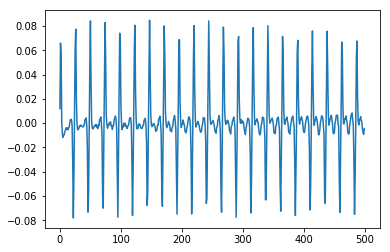

In [13]:
plt.plot(test.drop("Note", axis=1).iloc[0].values)

In [14]:
librosa.output.write_wav("E4.wav", test.drop("Note", axis=1).iloc[0].values, 8000)

In [15]:
ipd.Audio("E4.wav")

## Multi-file processing

Apply function to an entire directory

In [16]:
def dir_to_data(directory, rs, samples, note_table):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(samples)]+["Note"])
    pbar = tqdm(os.listdir(directory))
    
    for file in pbar:
        pbar.set_description("Processing %s" % file)
        df = file_to_data(directory + file, rs, samples, note_table)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    return data

In [17]:
data = dir_to_data("../../../Samples/Guitar/Ind_notes/", 8000, 500, note_table)

In [18]:
data.shape

(7175, 501)

In [10]:
librosa.output.write_wav("A3.wav", data[data["Note"] == "A3"].drop("Note", axis=1).sample().values.flatten(), 8000)

In [11]:
ipd.Audio("A3.wav")

In [53]:
data.to_pickle("../../../Data/Guitar/guitar-data-500.pkl")

In [7]:
data = dir_to_data("../../../Samples/Guitar/Ind_notes/", 8000, 200, note_table)

In [8]:
data.to_pickle("../../../Data/Guitar/guitar-data-200.pkl")

## 200 spectral

In the end this data was not used. This was basically to test whether short window spectral was useful to improve accuracy of note ID

In [9]:
%run ../Utilities/Utilities.ipynb

Using TensorFlow backend.


In [21]:
def file_to_data(file, rs, samples, note_table):
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = librosa.resample(y, sr, rs)

    df = pd.DataFrame(columns=["x{}".format(i) for i in range(samples)]+["Note"])
    string = file.split("/")[4].split("_")[2][-1]
    notes = strings[string]

    for i in tqdm(range(0, len(y), 4000), leave = False):
        note = y[i:i+4000]
        note = note[np.argwhere(note >= 0.001)[0][0]:]
        spectral = spectral_data(note, 200, False)
        spectral["Note"] = notes[int(i/4000)]
        df = df.append(spectral)
    df = df.reset_index(drop=True)
    return df

In [22]:
def dir_to_data(directory, rs, samples, note_table):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(samples)]+["Note"])
    pbar = tqdm(os.listdir(directory))
    
    for file in pbar:
        pbar.set_description("Processing %s" % file)
        df = file_to_data(directory + file, rs, samples, note_table)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    return data

In [23]:
data = dir_to_data("../../../Samples/Guitar/Ind_notes/", 8000, 200, note_table)

In [24]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x191,x192,x193,x194,x195,x196,x197,x198,x199,Note
0,0.083345,0.040067,0.055615,0.110169,0.119054,0.122097,0.112814,0.141393,0.154559,0.164121,...,0.009408,0.008045,0.006943,0.005929,0.005371,0.004903,0.004624,0.003528,0.004121,E4
1,0.011546,0.030534,0.045296,0.029801,0.036322,0.063610,0.067330,0.080423,0.085421,0.064237,...,0.007965,0.030686,0.015137,0.003015,0.001308,0.001375,0.001392,0.001499,0.001549,F4
2,0.004121,0.051698,0.028033,0.043443,0.070938,0.054980,0.044709,0.051558,0.087312,0.041959,...,0.005601,0.005346,0.006194,0.005593,0.004995,0.004647,0.004836,0.004674,0.004512,F#4
3,0.025529,0.059214,0.041460,0.044125,0.086061,0.069682,0.049919,0.088812,0.111628,0.147046,...,0.001218,0.002302,0.001540,0.002079,0.002009,0.000795,0.002221,0.002140,0.001876,G4
4,0.012147,0.051594,0.052993,0.055255,0.090433,0.090689,0.036614,0.058161,0.183797,0.070726,...,0.014750,0.015771,0.012089,0.010081,0.010157,0.009807,0.009482,0.009456,0.008779,G#4


In [25]:
data.to_pickle("../../../Data/Guitar/guitar-data-spectral-200.pkl")